# PollenCounter
Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)

## Imports

In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import imutils
import cv2
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from tqdm import tqdm
import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

print("Done")

Done


## Load Dataset

In [2]:
(ds_train, ds_val, ds_test), metadata = tfds.load("bee_dataset/bee_dataset_150",
                                                 split=["train[0%:70%]", "train[70%:85%]", "train[85%:100%]"],
                                                 shuffle_files=False,
                                                 as_supervised=True,
                                                 with_info=True)

category_index = {1: {'id': 1, 'name': 'regular'}, 2: {'id': 2, 'name': 'cooling'}, 3: {'id': 3, 'name': 'pollen'}, 4: {'id': 4, 'name': 'varroa'}, 5: {'id': 5, 'name': 'wasps'}}

print("Training set: {}, Validation set: {}, Test set: {}".format(len(list(ds_train)), len(list(ds_val)), len(list(ds_test))))

Training set: 5243, Validation set: 1123, Test set: 1124


## Data Augmentation

In [126]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
        path: a file path.

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
            and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
            this function assumes that the boxes to be plotted are groundtruth
            boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
        category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

def get_label(label):
    label = tfds.as_numpy(label.values())
    trans_label = []
    for j in range(len(label)):
        trans_label.append(label[j-1]*j)
    trans_label = np.array(int(np.sum(trans_label)))
    return list(category_index.values())[trans_label], tf.one_hot(trans_label, 5)

def zoom_image (new_image):
    DataGen = tf.keras.Sequential([
        layers.RandomZoom(0.2, 0.2)#, fill_mode="constant"),
    ])
    new_image = tf.cast(np.array(new_image), tf.float32)
    new_image = np.array(DataGen(new_image)).astype('uint8')
    return(new_image)

def extract_sub(new_image):
    #new_image = np.array(ds_entry[0])
    #label = tfds.as_numpy(ds_entry[1].values())

    new_image = np.array(new_image)
    t_lower = 0 # Lower Threshold
    t_upper = 150 # Upper threshold (higher yields less detail)
    aperture_size = 3 # Aperture size (default = 3)
    L2Gradient = False # Boolean (default = False)
    edges = cv2.Canny(new_image, t_lower, t_upper, apertureSize = aperture_size, L2gradient = L2Gradient) # 150, 75 confirmed
    
    w = int(list(tf.shape(new_image))[1]) #len(new_image[0]) 75 confirmed
    h = int(list(tf.shape(new_image))[0]) # 150 confirmed
    ymin = h
    xmin = w
    ymax = 0
    xmax = 0
    coords = [ymin, xmin, ymax, xmax]
    
    # Find left bound/xmin
    left_bound = np.zeros([h, w]) # 150, 75 confirmed
    row_track = 0
    while row_track <= h - 1:
        column_track = 0
        while column_track <= w - 1:
            value = edges[row_track, column_track]
            if (value > 0):
                left_bound[row_track][column_track:(w - 1)] = 1
                if (column_track < coords[1]):
                    coords[1] = column_track
                column_track = w
            column_track = column_track + 1
        row_track = row_track + 1
    
    # Find right bound/xmax
    right_bound = np.zeros([h, w])
    row_track = 0
    while row_track <= h - 1:
        column_track = w - 1
        while column_track >= 0:
            value = edges[row_track, column_track]
            if (value > 0):
                right_bound[row_track][0:column_track] = 1
                if (column_track > coords[3]):
                    coords[3] = column_track
                column_track = 0
            column_track = column_track - 1
        row_track = row_track + 1

    # Find top bound/ymin
    top_bound = np.zeros([w, h]) # 75, 150 confirmed
    column_track = 0
    while column_track <= w - 1:
        row_track = 0
        while row_track <= h - 1:
            value = edges[row_track, column_track]
            if (value > 0):
                top_bound[column_track][row_track:(h - 1)] = 1
                if (row_track < coords[0]):
                    coords[0] = row_track
                row_track = h
            row_track = row_track + 1
        column_track = column_track + 1
    top_bound = np.transpose(top_bound)
    
    # Find bottom bound/ymax
    bottom_bound = np.zeros([w, h])
    column_track = 0
    while column_track <= w - 1:
        row_track = h - 1
        while row_track >= 0:
            value = edges[row_track, column_track]
            if (value > 0):
                bottom_bound[column_track][0:row_track] = 1
                if (row_track > coords[2]):
                    coords[2] = row_track
                row_track = 0
            row_track = row_track - 1
        column_track = column_track + 1
    bottom_bound = np.transpose(bottom_bound)
    
    mask = top_bound * bottom_bound * right_bound * left_bound
    mask = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)
    mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2).astype(np.float32)

    new_image = new_image * mask
    new_image = Image.fromarray(new_image.astype(np.uint8))
    new_image = new_image.crop((coords[1], coords[0], coords[3], coords[2]))

    return new_image

def new_extract_sub(new_image, margin, sharp_value, alpha, beta):
    new_image = np.array(new_image)
    scale = 1;
    
    h, w, d = tf.shape(new_image)
    h = int(h*scale);
    w = int(w*scale);
    res = (w, h);

    # resize
    #new_image = cv2.resize(new_image, res);
    
    new_image = cv2.convertScaleAbs(new_image, alpha=alpha, beta=beta)
    plt.imshow(new_image)
    plt.show()
    
    # sharpen
    sharp_image = cv2.GaussianBlur(new_image, [0, 0], 3)
    new_image = cv2.addWeighted(new_image, sharp_value, sharp_image, 1 - sharp_value, 0)
    plt.imshow(new_image)
    plt.show()
    
    
    # change to hsv
    hsv = cv2.cvtColor(new_image, cv2.COLOR_BGR2HSV);
    h,s,v = cv2.split(hsv);

    # get uniques
    unique_colors, counts = np.unique(s, return_counts=True);

    # sort through and grab the most abundant unique color
    big_color = None;
    biggest = -1;
    for a in range(len(unique_colors)):
        if counts[a] > biggest:
            biggest = counts[a];
            big_color = int(unique_colors[a]);

    # get the color mask
    mask = cv2.inRange(s, big_color - margin, big_color + margin);

    # smooth out the mask and invert
    kernel = np.ones((3,3), np.uint8);
    mask = cv2.dilate(mask, kernel, iterations = 1);
    mask = cv2.medianBlur(mask, 5);
    mask = cv2.bitwise_not(mask);

    # crop out the image
    crop = np.zeros_like(new_image);
    crop[mask == 255] = new_image[mask == 255];
    
    # show
    plt.imshow(mask)
    plt.show()
    plt.imshow(crop)
    plt.show()
    plt.imshow(new_image)
    plt.show()
    
    #return mask, crop, new_image

def process_image(new_image):
    #new_image = tf.expand_dims(np.array(new_image), 0)
    #new_image = tf.reshape(new_image, [list(tf.shape(new_image))[1], list(tf.shape(new_image))[2], 3, 1])
    #print(np.shape(new_image))
    
    rotation_range=random.uniform(0, 360)
    new_image = new_image.rotate(rotation_range, Image.BILINEAR, expand = 1)
    h = np.shape(new_image)[0]
    w = np.shape(new_image)[1]
    #new_image = tf.image.resize(np.array(new_image), (h, w))
    #new_image = imutils.rotate_bound(np.array(new_image), rotation_range)
    h = np.shape(new_image)[0]
    w = np.shape(new_image)[1]
    
    coords = [0, 0, h, w]
    
    x_offset = tf.random.uniform((), 0 , tf.cast(640-w, tf.int32), dtype=tf.int32)
    y_offset = tf.random.uniform((), 0 , tf.cast(640-h, tf.int32), dtype=tf.int32)
    new_image = tf.image.resize(np.array(new_image), (h, w))
    new_image = tf.reshape(new_image, (list(np.shape(new_image))[0],list(np.shape(new_image))[1],3))
    new_image = tf.image.pad_to_bounding_box(new_image, y_offset, x_offset, 640, 640)
    #new_image = tf.cast(new_image, tf.float32)/255.0
    new_image = tf.cast(new_image, tf.uint8)
    
    coord_adder = [y_offset, x_offset, y_offset, x_offset]
    coords = np.array([sum(i) for i in zip(coords, coord_adder)])
    coords = np.array([(i / 640) for i in coords])

    return new_image, coords

def augment_set(dataset, training=True, num_images=None, set_name=None):
    if num_images == None:
        num_images = len(dataset)
        
    train_images_np = []
    gt_boxes = [0] * num_images
    train_labels = []
    subset = dataset.shuffle(len(dataset)).take(num_images)
    if set_name != None:
        with tqdm(total=num_images, desc=str(set_name), unit="images") as pbar:
            for i in range(num_images):
                new_image, label = next(iter(subset))
                try:
                    label = get_label(label)
                    train_labels.append(label)
                    new_image = zoom_image(new_image)
                    new_image = new_extract_sub(np.array(new_image))
                    new_image, new_coords = process_image(new_image)
                    train_images_np.append(np.array(new_image))
                    if training == True:
                        gt_boxes[i] = np.array([new_coords], dtype=np.float32)
                except:
                    pass
                pbar.update(1)
    else:
        with tqdm(total=num_images, unit="images") as pbar:
            for i in range(num_images):
                new_image, label = next(iter(subset))
                try:
                    label = get_label(label)
                    train_labels.append(label)
                    new_image = zoom_image(new_image)
                    new_image = new_extract_sub(np.array(new_image))
                    new_image, new_coords = process_image(new_image)
                    train_images_np.append(np.array(new_image))
                    if training == True:
                        gt_boxes[i] = np.array([new_coords], dtype=np.float32)
                except:
                    pass
                pbar.update(1)
    if training:
        print('Succeeded for ' + str(len(train_images_np)) + ' of ' + str(num_images), flush=True)
        return train_images_np, gt_boxes, train_labels
    else:
        print('Succeeded for ' + str(len(train_images_np)) + ' of ' + str(num_images), flush=True)
        return train_images_np

print("Done")

Done


## Augment images

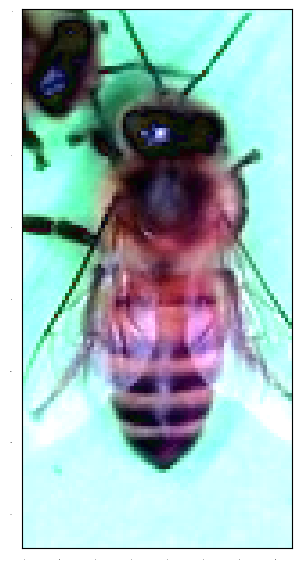

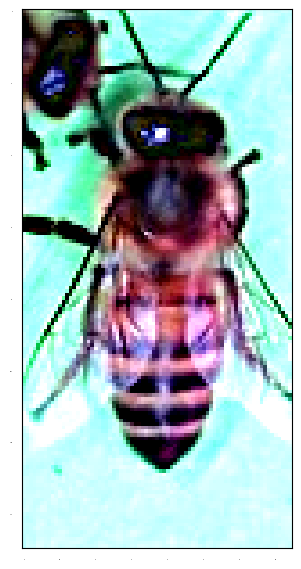

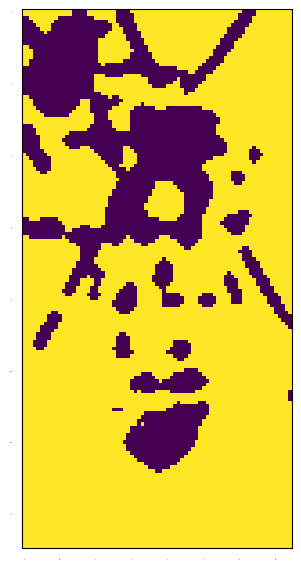

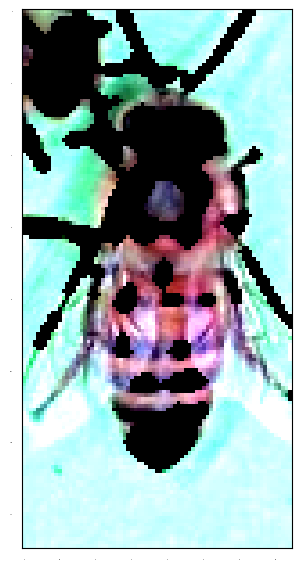

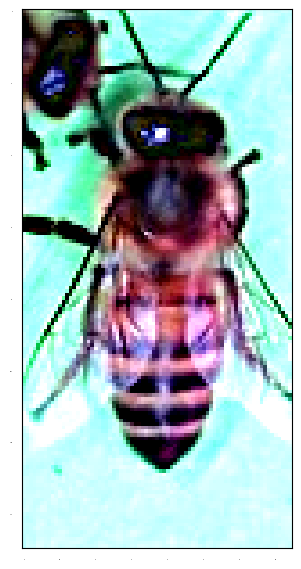

Done


In [149]:
#train_images_np, gt_boxes, train_labels = augment_set(ds_train, set_name="Augment training images")
test_image, test_label = next(iter(ds_train.shuffle(len(ds_train)).take(1)))

# new_image, margin (higher = greater removal), sharp_value (0 - 2, higher = sharper),
# alpha (contrast, 0 < 1 = lower contrast, 1 = neutral, x > 1 = higher contrast), beta (brightness, -127 < x < 127, 0 = neutral, higher = brighter)

new_extract_sub(test_image, 10, 2, 2, -100)
'''
train_images_np, gt_boxes, train_labels = augment_set(ds_train, num_images=10, set_name="Augment training images")
#test_images_np = augment_set(ds_test, training=False, set_name="Augment test images")
test_images_np = augment_set(ds_test, training=False, num_images=10, set_name="Augment test images")

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np[0:6]):
    plt.subplot(2, 3, idx+1)
    plt.title((train_labels[idx])[0]['name'])
    plt.imshow(train_image_np)
plt.show

# By convention, our non-background classes start counting at 1.
num_classes = 5

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
item_num = np.shape(train_images_np)[0]
with tqdm(total=np.shape(train_images_np)[0], unit="images", desc=str("Prep training images")) as pbar:
    for (train_image_np, gt_box_np) in zip(train_images_np, gt_boxes):
        try:
            train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0))
            gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
            zero_indexed_groundtruth_classes = tf.convert_to_tensor(np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
            gt_classes_one_hot_tensors.append(tf.one_hot(zero_indexed_groundtruth_classes, num_classes))
        except:
            pass
        pbar.update(1)

print('Done prepping data.')
print('Succeeded for ' + str(len(train_image_tensors)) + ' of ' + str(item_num), flush=True)
'''
print("Done")

# Let's just visualize the images as a sanity check

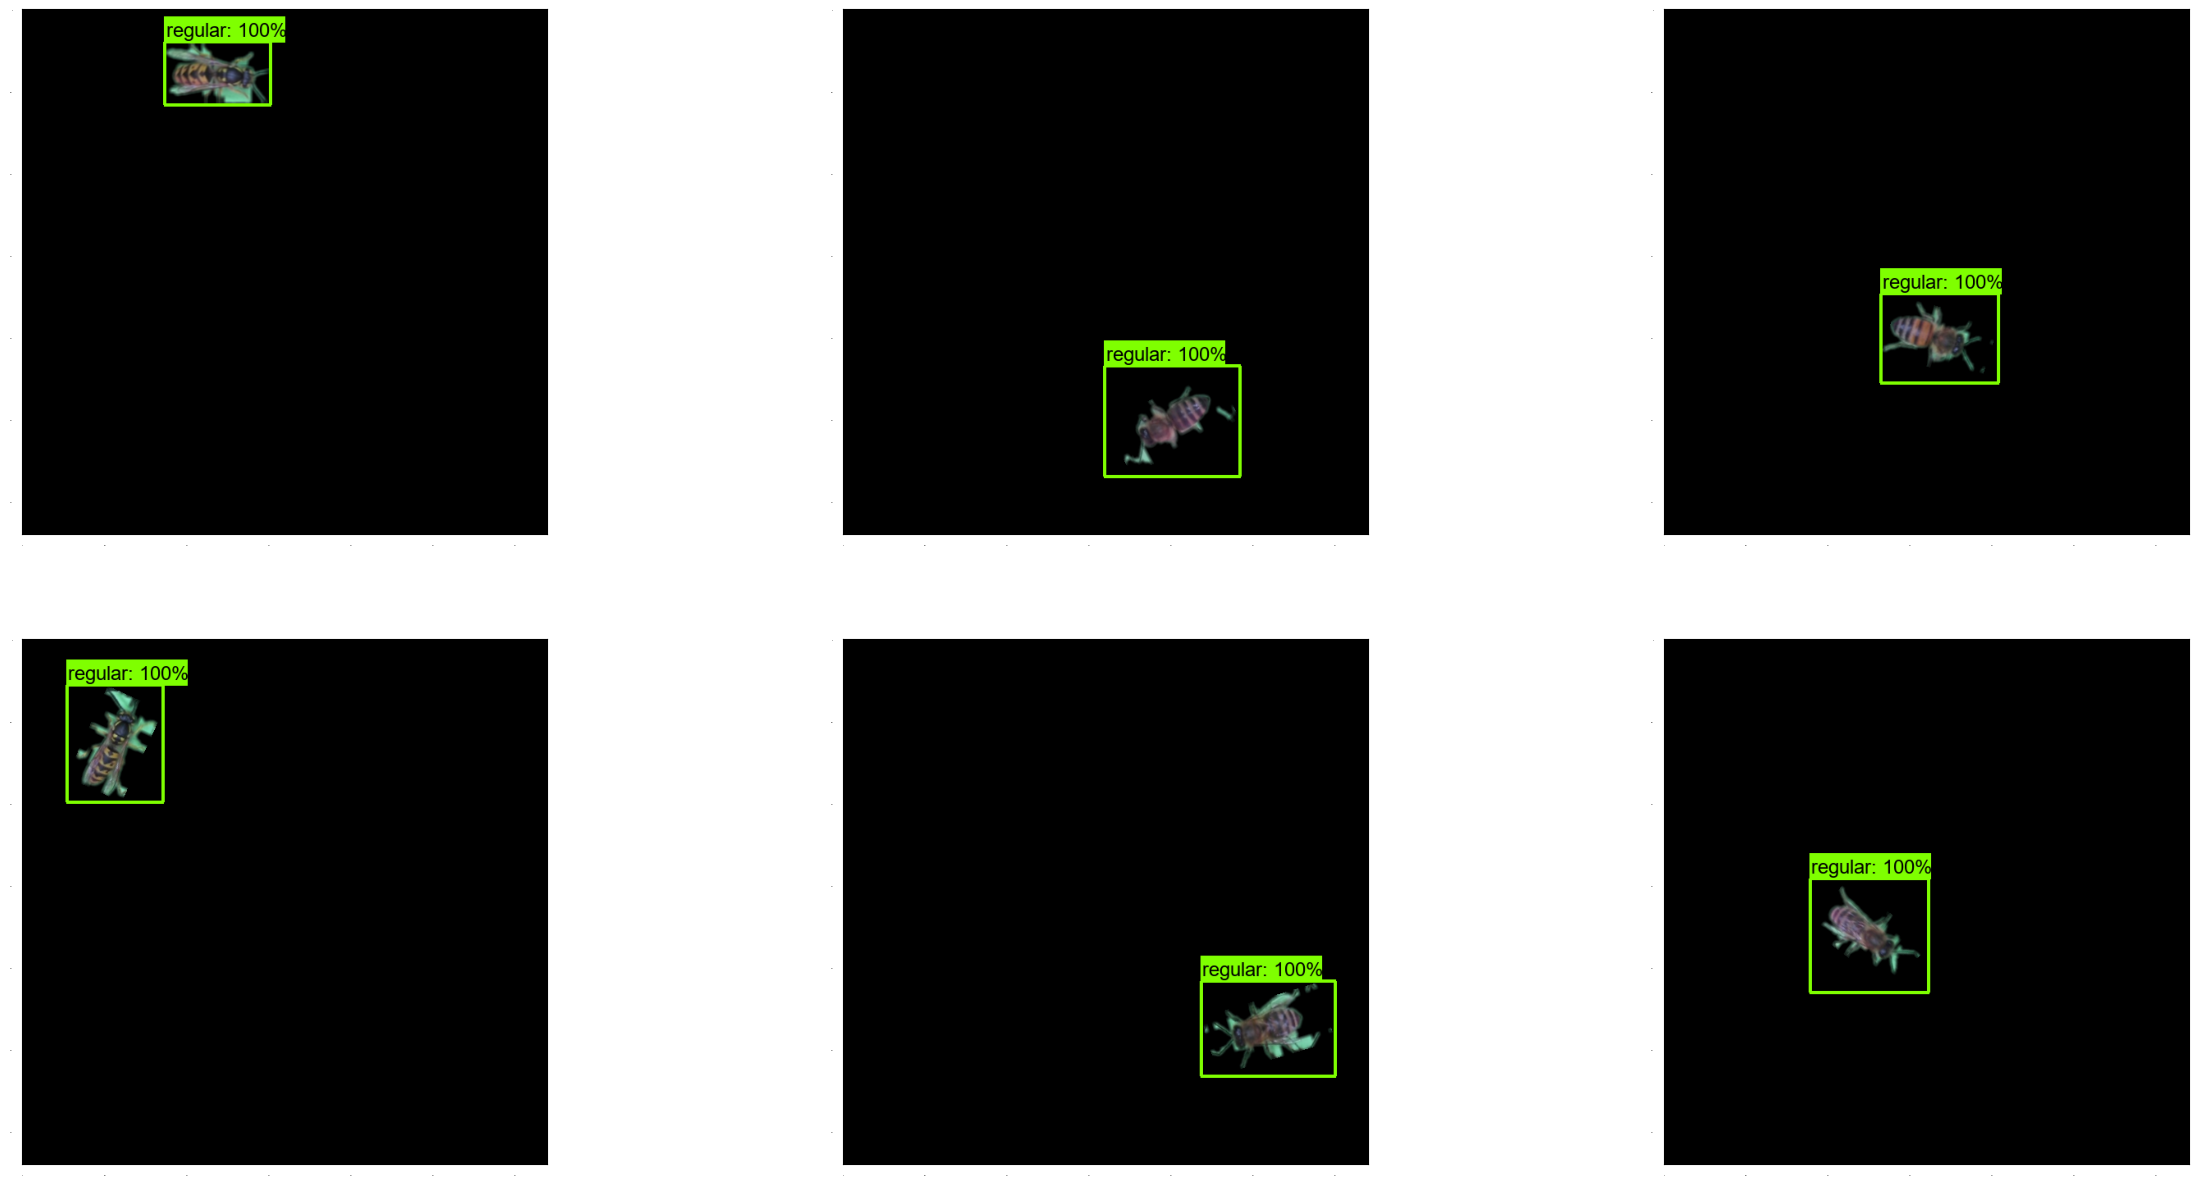

In [67]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(6):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [10]:
# Clone the tensorflow models repository if it doesn't already exist
if "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar" in pathlib.Path.cwd().parts:
    !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/
elif not pathlib.Path('models').exists():
    # Download the checkpoint and put it into models/research/object_detection/test_data/
    !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
    !mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

print("Done")

Done


In [11]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 5
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [13]:
#tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 64
learning_rate = 0.01
num_batches = round(len(train_image_tensors) / batch_size)

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
        """A single training iteration.

        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth boxes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
with tqdm(total = num_batches, unit="batchs") as pbar:
    for idx in range(num_batches):
        # Grab keys for a random subset of examples
        all_keys = list(range(len(train_images_np)))
        random.shuffle(all_keys)
        example_keys = all_keys[:batch_size]

        # Note that we do not do data augmentation in this demo.  If you want a
        # a fun exercise, we recommend experimenting with random horizontal flipping
        # and random cropping :)
        gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
        gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
        image_tensors = [train_image_tensors[key] for key in example_keys]

        # Training step (forward pass + backwards pass)
        total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

        #if idx % 10 == 0:
            #print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)
        pbar.set_postfix(loss=total_loss.numpy())
        pbar.update(1)

print('Done fine-tuning!')

Start fine-tuning!


100%|██████████████████████████████████████████████████████████████████| 82/82 [22:44<00:00, 16.64s/batchs, loss=0.221]

Done fine-tuning!


# Load test images and run inference with new model!

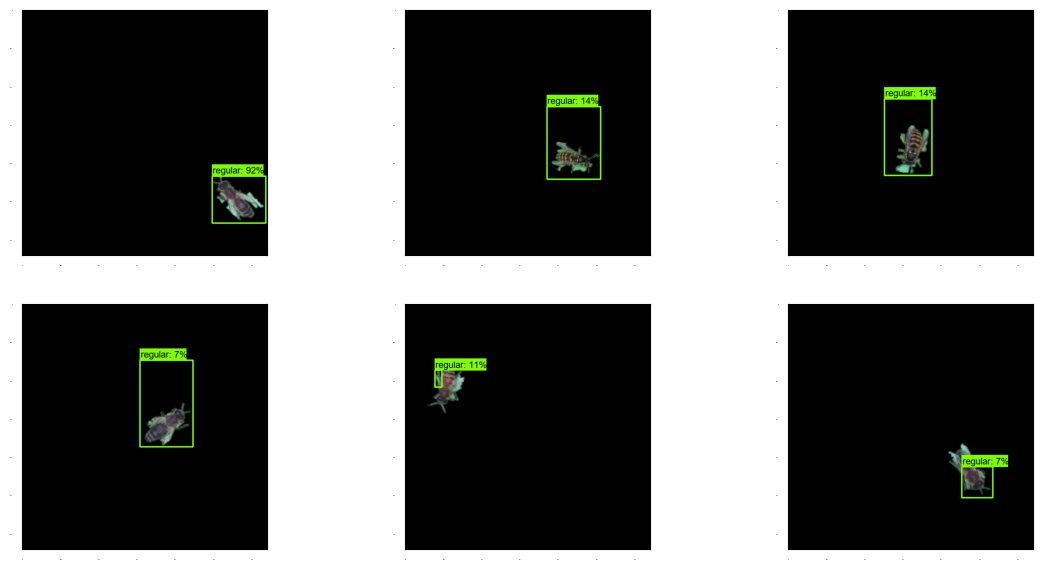

Done


In [70]:
'''
test_image_dir = 'models/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
    image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))
'''

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

    Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(6):
    plt.subplot(2, 3, i+1)
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    input_tensor = tf.expand_dims(input_tensor, 0)
    detections = detect(input_tensor)

    plot_detections(
        test_images_np[i],
        np.array([detections['detection_boxes'][0][i]]),
        [(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)[i]],
        [(detections['detection_scores'][0].numpy())[i]],
        category_index, figsize=(15, 20))
plt.show()

print("Done")